# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.112449,True,5.797450
1,-0.677125,True,3.838380
2,-0.695241,True,3.620365
3,2.075776,True,8.163674
4,3.092924,False,6.162368
...,...,...,...
995,0.531328,True,4.667746
996,1.426394,True,8.728339
997,1.185393,False,2.244934
998,-0.768561,True,4.260798


<AxesSubplot:xlabel='v0'>

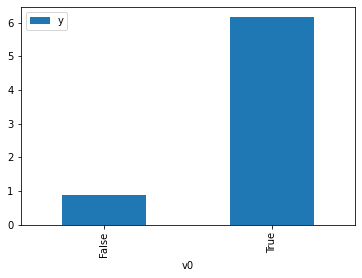

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

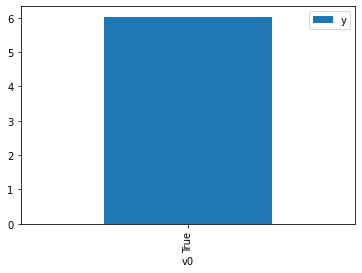

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.171226,False,-0.210401,0.496312,2.014862
1,0.851290,False,2.565760,0.499079,2.003691
2,2.163313,False,3.018790,0.504417,1.982486
3,0.587099,False,2.439630,0.498004,2.008016
4,-0.536517,False,-0.615344,0.493433,2.026619
...,...,...,...,...,...
995,-0.292366,False,-1.129458,0.494426,2.022548
996,1.669871,False,1.499453,0.502409,1.990408
997,-1.021532,False,-0.876728,0.491460,2.034755
998,-0.725833,False,-2.131689,0.492662,2.029788


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.540567,True,5.507358,0.502185,1.991296
1,1.670308,True,7.785939,0.497589,2.009692
2,1.797658,True,7.896187,0.497071,2.011787
3,2.484465,True,8.629853,0.494276,2.023160
4,-0.521330,True,3.454642,0.506506,1.974312
...,...,...,...,...,...
995,0.011707,True,4.584600,0.504337,1.982801
996,-0.027784,True,4.863627,0.504498,1.982169
997,0.474427,True,4.601139,0.502455,1.990230
998,-0.029462,True,7.075096,0.504505,1.982142


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.098e+04
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                        0.00
Time:                        02:02:02   Log-Likelihood:                         -1402.0
No. Observations:                1000   AIC:                                      2808.
Df Residuals:                     998   BIC:                                      2818.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6402      0.028     57.919      0.000       1.585       1.696
x2             5.0445      0.047    107.614      0.000       4.952       5.136
==============================================================================
Omnibus:                        4.561   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.420
Skew:                           0.153   Prob(JB):                        0.110
Kurtosis:                       3.113   Cond. No.                         1.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""